# 2D Spot Detection with ImageJ

## Discipline: Spot / object counting (SptCnt)

Task: Estimate the number of objects

This project illustrates the 2D counting of small vesicle like objects.

## The input images

The images were generated by [SIMCEP](http://www.cs.tut.fi/sgn/csb/simcep/tool.html), a widefield fluorescence microscopy biological images simulator.

First set paths to the input and ground-truth folders and create the output folder.

In [1]:
IN_FOLDER = "/home/jovyan/data/in/"
GT_FOLDER = "/home/jovyan/data/gt/"
OUT_FOLDER = "/home/jovyan/data/out/"

!mkdir -p $OUT_FOLDER

The input images are in the ome-tif format.

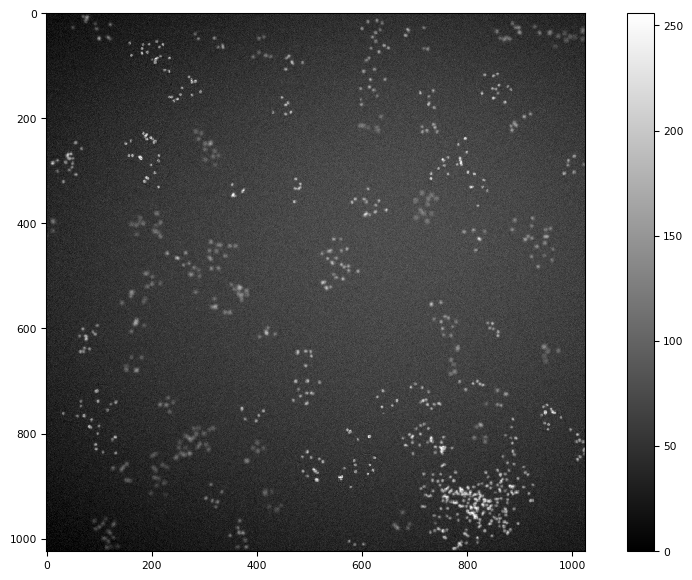

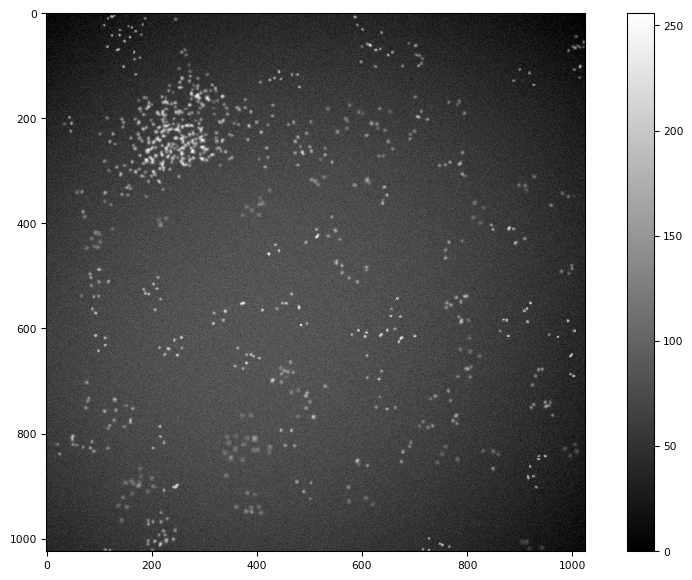

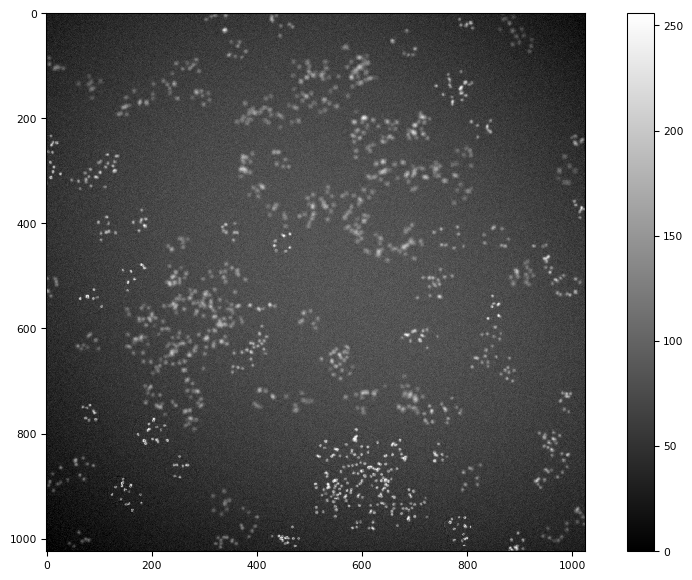

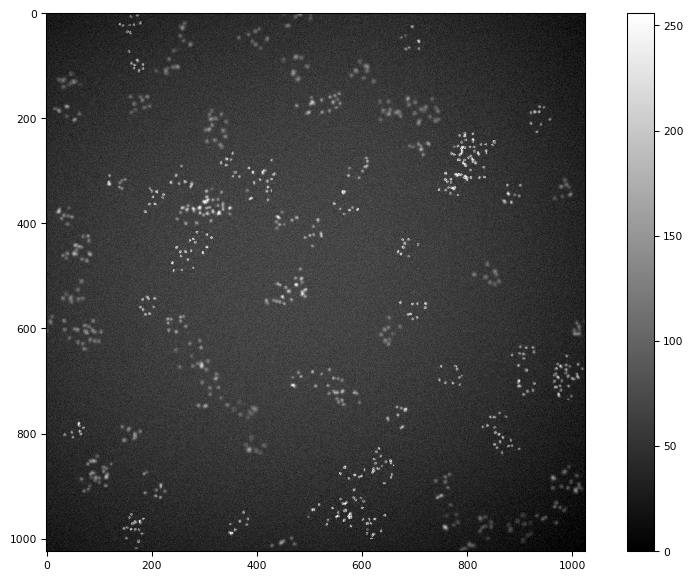

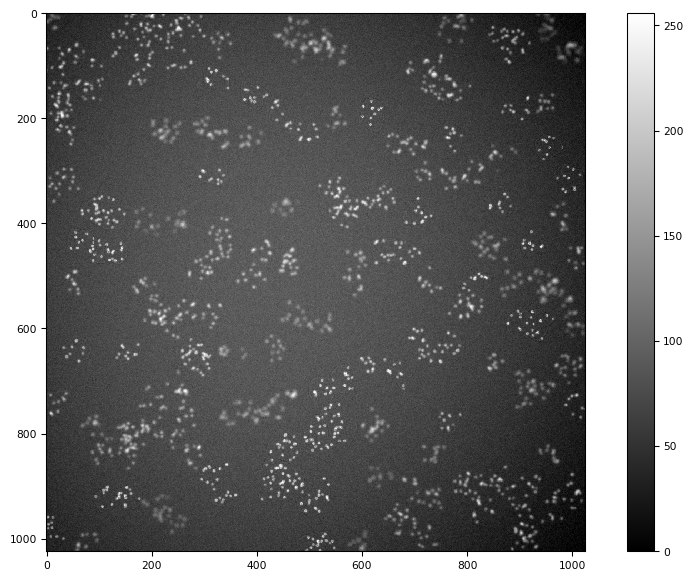

In [3]:
import os
import tifffile
import matplotlib.pyplot
files = [i.path for i in os.scandir(IN_FOLDER) if i.is_file()]
paths_sources = [i for i in files if ('.tif' in i) ]
sources = []
for path in paths_sources:
    source = tifffile.imread(path)
    tifffile.imshow(source, cmap='gray')
    sources.append(source)
 

## The image analysis workflow

The ImageJ macro uses the Laplacian of Gaussian filter from [FeatureJ](https://imagej.net/FeatureJ) with the given standard deviation of the Gaussian derivative kernels and detects the minima with the given noise tolerance.

In [4]:
from IPython.display import display, Code
code = Code(url='https://raw.githubusercontent.com/Neubias-WG5/W_SpotDetection-IJ/f2d8bd9a2ff74e56d9c80a98f0ab73838caca029/IJSpotDetection.ijm')
display(code)

// Author: Sébastien Tosi (IRB Barcelona)
// Version: 1.0
// Date: 21/04/2017

// The default input and output folder
inputDir = "/dockershare/667/in/";
outputDir = "/dockershare/667/out/";

// Functional parameters
LapRad = 2;
NoiseTol = 2.5;

arg = getArgument();
parts = split(arg, ",");

setBatchMode(true);
for(i=0; i<parts.length; i++) {
	nameAndValue = split(parts[i], "=");
	if (indexOf(nameAndValue[0], "input")>-1) inputDir=nameAndValue[1];
	if (indexOf(nameAndValue[0], "output")>-1) outputDir=nameAndValue[1];
	if (indexOf(nameAndValue[0], "radius")>-1) LapRad=nameAndValue[1];
	if (indexOf(nameAndValue[0], "noise")>-1) NoiseTol=nameAndValue[1];
}

images = getFileList(inputDir);

for(i=0; i<images.length; i++) {
	image = images[i];
	if (endsWith(image, ".tif")) {
		// Open image
		open(inputDir + "/" + image);
		width = getWidth();
		height = getHeight();
		
		// Processing
		run("Clear Results", "");
		run("FeatureJ Laplacian", "compute smoothing="+d2s(LapRad,2));
		run("Find Maxima...", "noise="+d2s(NoiseTol,2)+" output=List light");
		
		// Export results
		newImage("Mask", "16-bit black", width, height, 1);
		for(r=0;r<nResults;r++)
		{
			XPos = getResult("X",r);
			YPos = getResult("Y",r);
			setPixel(XPos,YPos,65535);			
		}
		save(outputDir + "/" + image);
		// Cleanup
		run("Close All");
	}
}
run("Quit");

In [5]:
STD_DEV = 2
NOISE = 2.5

In [2]:
!ls /home/jovyan/data

gt  in	out


In [6]:
!python /app/wrapper.py  --ij_radius $STD_DEV --ij_noise $NOISE --infolder $IN_FOLDER --gtfolder $GT_FOLDER --outfolder $OUT_FOLDER --nodownload --noexport --nometrics

Progress: 0  % ... Status: 2 - 'Running workflow for problem class 'SptCnt' in 2D'
Progress: 0  % ... Status:   - 'Initialisation...'
Progress: 25 % ... Status:   - 'Launching workflow...'
Progress: 90 % ... Status:   - 'Computing and uploading metrics...'
Progress: 100% ... Status: 3 - 'Finished.'


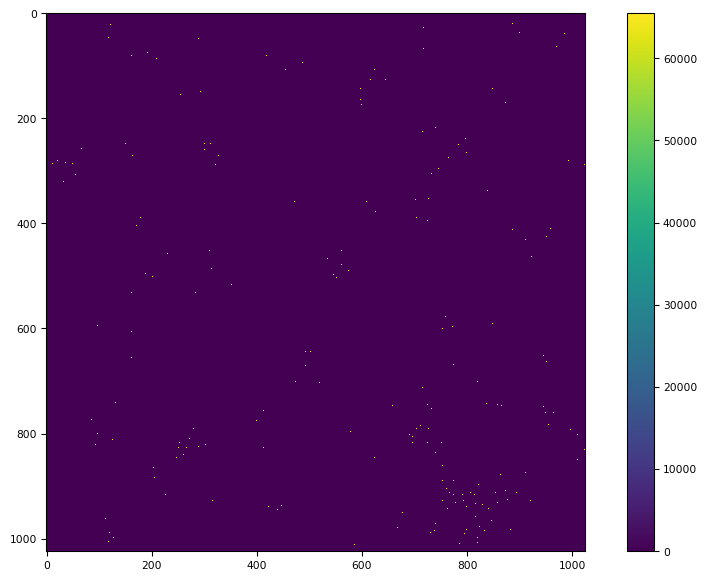

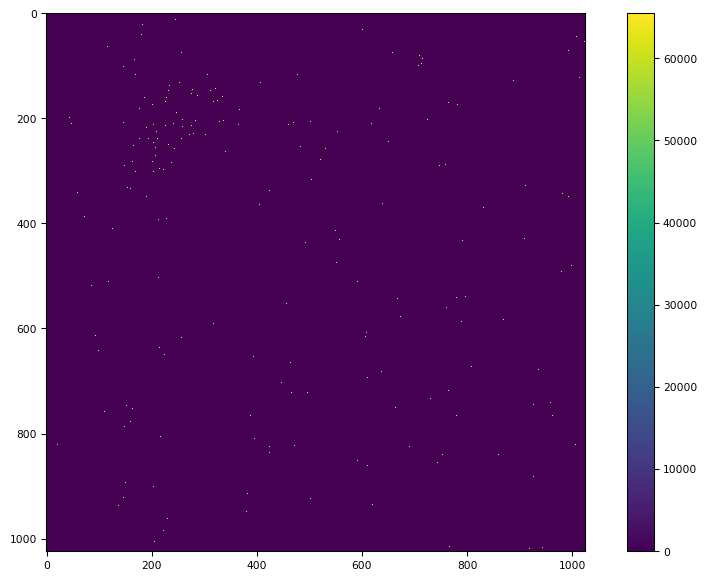

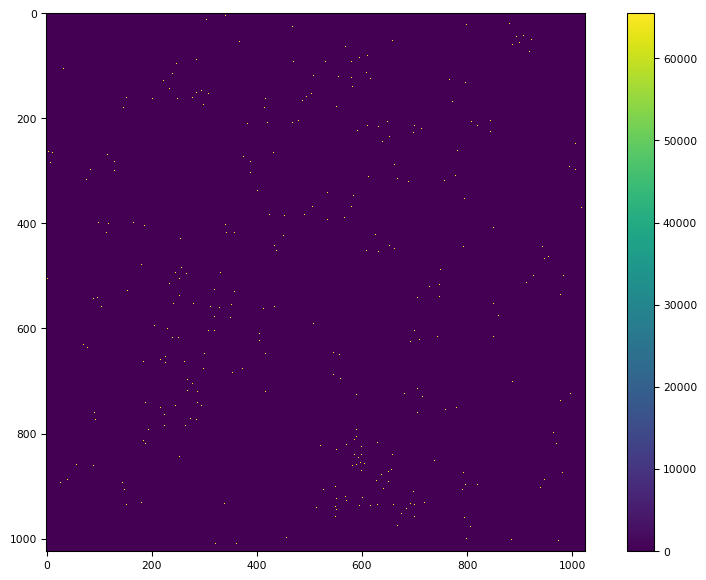

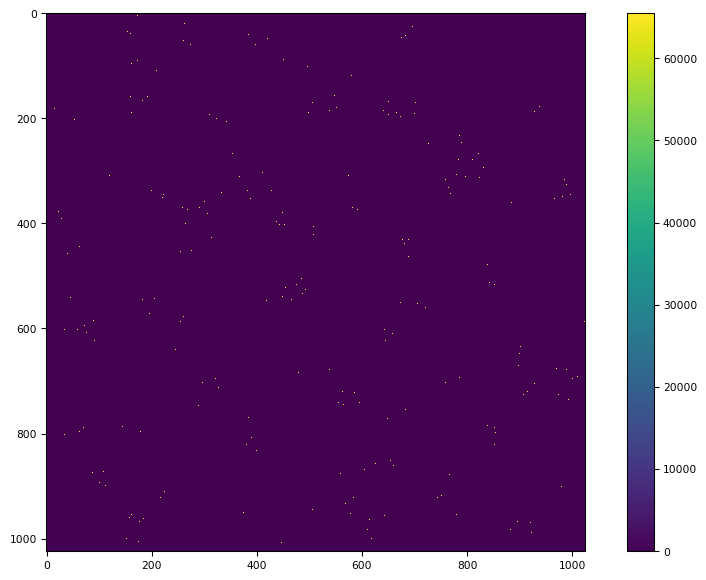

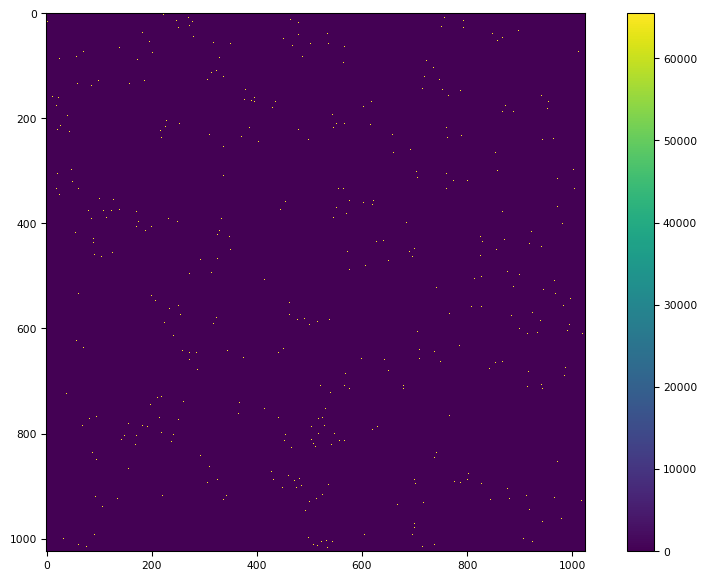

In [7]:
files = [i.path for i in os.scandir(OUT_FOLDER) if i.is_file()]
paths_sources = [i for i in files if ('.tif' in i) ]
sources = []
for path in paths_sources:
    source = tifffile.imread(path)
    tifffile.imshow(source)
    sources.append(source)